In [30]:
# Import the huggingface dataset
from datasets import load_dataset

import pandas as pd
import numpy as np

# DL
import torch
from torch.utils.data import Dataset

# Statistics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy import stats

# For text processing
import re
import string

# For sentiment analysis
from textblob import TextBlob

# For BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [32]:
# BERT on the train_dl created
train_dl = pd.read_csv('balanced_data_files/train_dl.csv')
val_dl = pd.read_csv('balanced_data_files/val_dl.csv')

print(train_dl.head())
print(train_dl.shape)
print(train_dl.info())
print(train_dl.columns)

                                          Email Text  label
0  re : rolex order details - m 3945 s rolex : $ ...      1
1  aisb96 call for workshop proposals - - - - - -...      0
2  query : not not dear linguists , i am working ...      0
3  Update of /cvsroot/spamassassin/spamassassin/m...      0
4  URL: http://boingboing.net/#85482211\nDate: No...      0
(13054, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13054 entries, 0 to 13053
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  13041 non-null  object
 1   label       13054 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 204.1+ KB
None
Index(['Email Text', 'label'], dtype='object')


count    1.305400e+04
mean     6.125063e+02
std      3.088025e+04
min      0.000000e+00
25%      7.400000e+01
50%      1.600000e+02
75%      3.550000e+02
max      3.527576e+06
Name: text_length, dtype: float64


D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_g

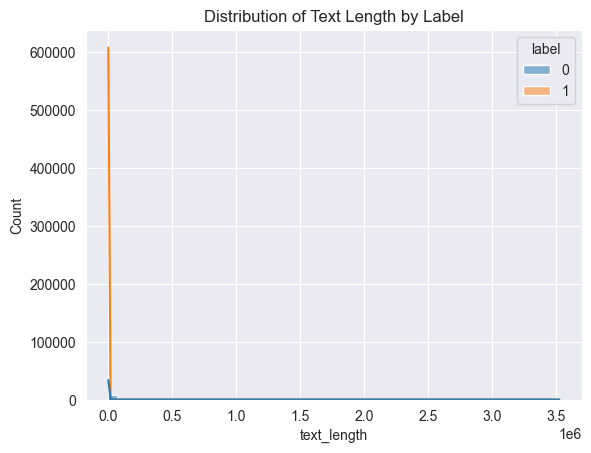

In [33]:
# Cell 4: Exploratory Data Analysis (EDA)

# Rename 'Email Text' to 'text' for convenience (optional)
train_dl = train_dl.rename(columns={'Email Text': 'text'})

# Look at text lengths
train_dl['text_length'] = train_dl['text'].apply(lambda x: len(str(x).split()))
print(train_dl['text_length'].describe())

# Quick plot of text length by label
sns.histplot(data=train_dl, x='text_length', hue='label', bins=50, kde=True)
plt.title("Distribution of Text Length by Label")
plt.show()

In [34]:
# Check for missing values
print("Number of NaN values in text column:", train_dl['text'].isna().sum())

Number of NaN values in text column: 13


In [35]:
def clean_text(text):
    # Check if text is NaN or None
    if isinstance(text, float) and pd.isna(text):
        return ""  # Return empty string for NaN values

    # Convert to string to handle any numeric values
    text = str(text)

    # Example: remove HTML tags, if any
    text = re.sub(r'<.*?>', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

train_dl['clean_text'] = train_dl['text'].apply(clean_text)

# Show a sample
print(train_dl['clean_text'].iloc[0])

re : rolex order details - m 3945 s rolex : $ 129 cartier : $ 119 and more ? no thanks -


In [36]:
# Cell 6:  Linguistic Features (Sentiment Analysis)

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # ranges from -1 (negative) to +1 (positive)

train_dl['sentiment'] = train_dl['clean_text'].apply(get_sentiment)         # Original
print(train_dl[['clean_text', 'sentiment']].head(10))


                                          clean_text  sentiment
0  re : rolex order details - m 3945 s rolex : $ ...   0.200000
1  aisb96 call for workshop proposals - - - - - -...   0.027022
2  query : not not dear linguists , i am working ...   0.036392
3  Update of /cvsroot/spamassassin/spamassassin/m...   0.067273
4  URL: http://boingboing.net/#85482211 Date: Not...  -0.030556
5  wc 551 revision and notice of force majeure ( ...   0.016667
6  clean ur computer now 3 ey there is a 85 % cha...  -0.108333
7  3 locations free : orlando , las vegas , ft la...   0.294582
8  re : the virtual girlfriend and virtual boyfri...   0.170754
9  re : probation period - matthew williams hi ka...   0.190833


D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


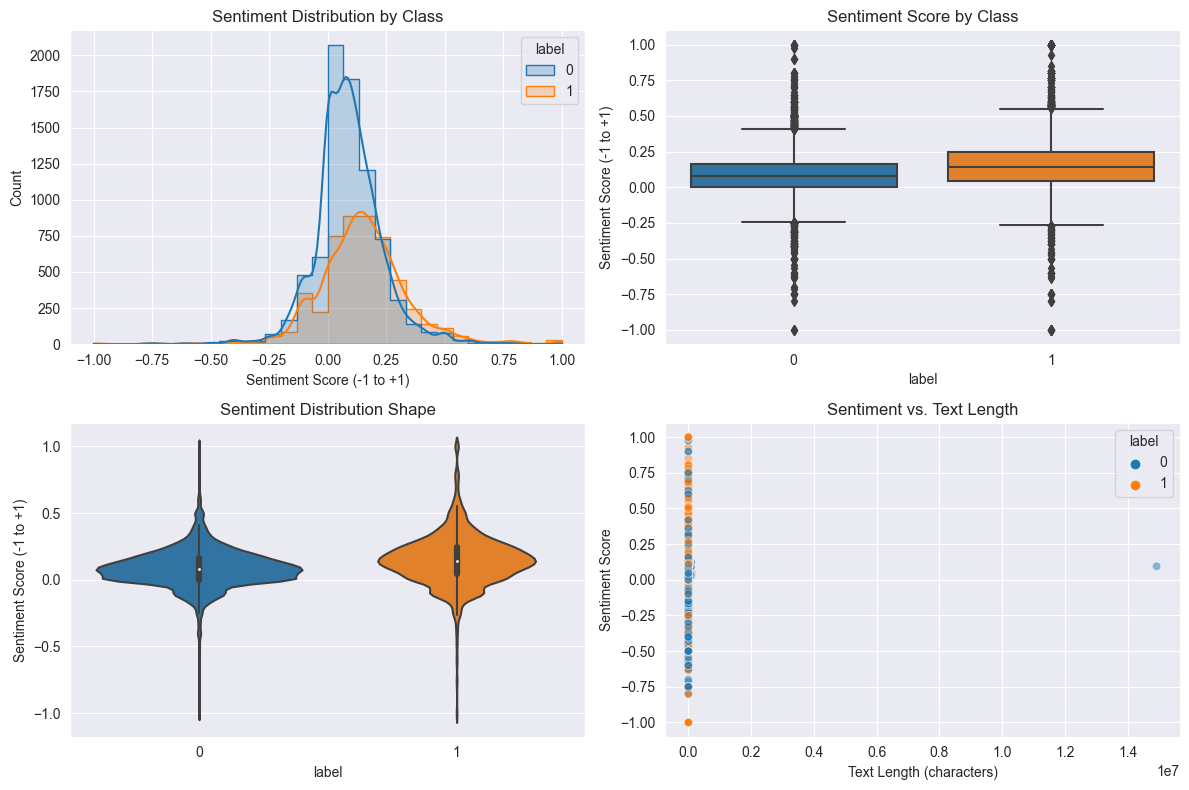

Non-phishing (Safe) Sentiment Statistics:
count    7924.000000
mean        0.088843
std         0.146831
min        -1.000000
25%         0.000000
50%         0.082006
75%         0.163889
max         1.000000
Name: sentiment, dtype: float64

Phishing Sentiment Statistics:
count    5130.000000
mean        0.150151
std         0.192059
min        -1.000000
25%         0.041557
50%         0.144723
75%         0.247535
max         1.000000
Name: sentiment, dtype: float64

T-test results: t-statistic = -19.4738, p-value = 0.000000
Statistically significant difference: True
safe Sentiment Statistics:
count    7924.000000
mean        0.088843
std         0.146831
min        -1.000000
25%         0.000000
50%         0.082006
75%         0.163889
max         1.000000
Name: sentiment, dtype: float64

phish Sentiment Statistics:
count    5130.000000
mean        0.150151
std         0.192059
min        -1.000000
25%         0.041557
50%         0.144723
75%         0.247535
max         1.000000

In [37]:
# Visualizing sentiment distribution
plt.figure(figsize=(12, 8))

# Plot 1: Sentiment distribution by class
plt.subplot(2, 2, 1)
sns.histplot(data=train_dl, x='sentiment', hue='label', element='step', bins=30, kde=True)
plt.title('Sentiment Distribution by Class')
plt.xlabel('Sentiment Score (-1 to +1)')

# Plot 2: Box plot of sentiment by class
plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='sentiment', data=train_dl)
plt.title('Sentiment Score by Class')
plt.ylabel('Sentiment Score (-1 to +1)')

# Plot 3: Violin plot to see distribution shape
plt.subplot(2, 2, 3)
sns.violinplot(x='label', y='sentiment', data=train_dl)
plt.title('Sentiment Distribution Shape')
plt.ylabel('Sentiment Score (-1 to +1)')

# Plot 4: Scatter plot of text length vs sentiment
train_dl['text_length'] = train_dl['clean_text'].apply(len)
plt.subplot(2, 2, 4)
sns.scatterplot(x='text_length', y='sentiment', hue='label', data=train_dl, alpha=0.5)
plt.title('Sentiment vs. Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Sentiment Score')

plt.tight_layout()
plt.show()

# Statistical analysis - use numeric values 0 and 1 instead of 'safe' and 'phish'
safe_sentiment = train_dl[train_dl['label'] == 0]['sentiment']  # 0 for non-phishing
phish_sentiment = train_dl[train_dl['label'] == 1]['sentiment'] # 1 for phishing

print("Non-phishing (Safe) Sentiment Statistics:")
print(safe_sentiment.describe())
print("\nPhishing Sentiment Statistics:")
print(phish_sentiment.describe())

# Run t-test to compare sentiment means
t_stat, p_value = stats.ttest_ind(safe_sentiment, phish_sentiment, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
print(f"Statistically significant difference: {p_value < 0.05}")
print("safe Sentiment Statistics:")
print(safe_sentiment.describe())
print("\nphish Sentiment Statistics:")
print(phish_sentiment.describe())

# Run t-test to compare sentiment means
t_stat, p_value = stats.ttest_ind(safe_sentiment, phish_sentiment, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
print(f"Statistically significant difference: {p_value < 0.05}")

In [38]:
# Cell 8: Tokenization & Dataset Preparation

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, 'clean_text']
        # Use the numeric label directly (0 for non-phishing, 1 for phishing)
        label = self.df.loc[idx, 'label']

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Use your existing split datasets
train_dataset = EmailDataset(train_dl, tokenizer)
val_dataset = EmailDataset(val_dl, tokenizer)

print("Tokenization complete!")

Tokenization complete!


D:\.venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
# Cell 9: BERT Model & Trainer
# Updated EmailDataset class with proper column handling
class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Try using 'text' instead of 'clean_text'
        # If 'text' doesn't exist, try 'Email Text'
        if 'text' in self.df.columns:
            text = self.df.loc[idx, 'text']
        elif 'Email Text' in self.df.columns:
            text = self.df.loc[idx, 'Email Text']
        else:
            # Print column names to help debug
            print(f"Available columns: {self.df.columns.tolist()}")
            raise KeyError("Could not find text column. Please specify the correct column name.")

        # Use the numeric label directly
        label = self.df.loc[idx, 'label']

        # Ensure text is a string
        text = str(text) if text is not None else ""

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets with the updated EmailDataset class
train_dataset = EmailDataset(train_dl, tokenizer)
val_dataset = EmailDataset(val_dl, tokenizer)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=1,         # adjust as needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model='accuracy',  # Use accuracy to determine the best model
    report_to='none'  # Disable reporting to avoid any potential issues
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Add metrics computation
)

trainer.train()

D:\.venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.036700,0.068448,0.979271,0.973897,0.963491,0.984531


TrainOutput(global_step=1632, training_loss=0.13261332866900108, metrics={'train_runtime': 352.3185, 'train_samples_per_second': 37.052, 'train_steps_per_second': 4.632, 'total_flos': 858662929167360.0, 'train_loss': 0.13261332866900108, 'epoch': 1.0})

In [ ]:
# Cell 10: Evaluation & Prediction
# Need to edit
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Predict on a few validation samples
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Compare with true labels
true_labels = val_df['label'].map(label_map).values
accuracy = np.mean(pred_labels == true_labels)
print(f"Validation Accuracy: {accuracy:.2f}")


In [ ]:
# Cell 11: More evaluation Metrics
# Need to edit

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# After your model has made predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Calculate metrics
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# For a more comprehensive report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['ham', 'phishing']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(labels, preds)
print(cm)